In [2]:
#from the py_geospatial environment
import glob
import os
import baseflow #this is the baseflow package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pickle
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature  
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

#use segoe font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Segoe UI'

#### Read observed discharge data

Observed discharge data from all station was pickled from the flow_evaluation notebook

In [3]:
#flow data
src = "W:/VUB/_main_research/mHM/model_validation_data/waterinfo_csv/waterinfo_timeseries"
base_dir = r"D:\VUB\_data\_isimip_3b\model_outputs"

#pickled Q data for all stations (from the flow_evaluation.ipynb script)
with open(os.path.join(base_dir, 'eval_stations_Q.pickle'), 'rb') as f:
    eval_stations_Q = pickle.load(f)

#station coordinates
station_locations = pd.read_csv("mHM_eval_stations.csv")

#Boundaries data
be_shp = gpd.read_file(r"W:/VUB/_main_research/mHM/mhm_belgium/be_shp/be.shp")

#rivers
rivers_shp = gpd.read_file(r"W:/VUB/_main_research/data/shapefiles/HydroRIVERS_v10_eu_shp/HydroRIVERS_v10_eu_shp/hydroRivers_BE.shp")

#### Remove canals

In [4]:
canals = ['HACCOURT', 'Merendree_Afleidingskl Leie', 'Damme_Leopoldkl']

#remove the canals from the eval stations DICTIONARY
for canal in canals:
    if canal in eval_stations_Q:
        del eval_stations_Q[canal]
        print(f"Removed {canal} from the evaluation stations dictionary", end='\r')
    else:
        print(f"{canal} not found in the evaluation stations dictionary")

#### Baseflow filter with different methods

In [5]:
#dictionary to store the results
baseflow_dict_stations= {}
bfi_dict = {}
kge_dict = {}
coords_dict = {}


for key, data in eval_stations_Q.items():
    #read the data
    nameStation = key

    df = eval_stations_Q[nameStation]

    #drop duplicate station names
    station_locations.drop_duplicates(subset=['name'], inplace=True)

    #select the station location
    lat = station_locations.loc[station_locations['name'] == nameStation, 'lat'].values[0]
    lon = station_locations.loc[station_locations['name'] == nameStation, 'lon'].values[0]


    print(f'Processing {nameStation}', end='\r')
    baseflow_dict, bfi, df_kge = baseflow.separation(df, return_bfi=True, return_kge=True) # to select a method, use the `method` parameter

    #choose best method based on KGE
    best_method = df_kge.idxmax(axis=1).iloc[0]  #iloc[0] grabs the station name from the index

    #extract the KGE for the best method
    kge_dict[nameStation] = np.round(df_kge[best_method].iloc[0], 3)

    #store the coordinates
    coords_dict[nameStation] = (lon, lat)

    #extract the baseflow timeseries for the best method
    df_Qb = baseflow_dict[best_method]

    #get the bfi based on the best method
    bfi_dict[nameStation] = np.round(bfi[best_method].iloc[0],3)

    #Get the Qtotal and Qbaseflow for the station
    df_stat = pd.concat([df, df_Qb], axis=1)
    df_stat.columns = ['Q', 'Q_bf']

    baseflow_dict_stations[nameStation] = df_stat

#### Seasonal BFI
Calculate BFI separately for each meteorological season: winter: DJF, spring: MAM, Summer: JJA and autumn: SON

In [6]:
seasons = {
    'DJF': [12, 1, 2],  # December, January, February
    'MAM': [3, 4, 5],   # March, April, May
    'JJA': [6, 7, 8],   # June, July August
    'SON': [9, 10, 11]  # September, October, November
}


# List to hold seasonal baseflow DataFrames for each station
station_Qb = []

# Loop through each station and calculate seasonal baseflow
for nameStation, df in baseflow_dict_stations.items():

    seasonal_baseflow_dict = {}

    for season, months in seasons.items():
        # Initialize a dictionary to hold seasonal data for the station

        # Filter the DataFrame for the current season
        season_df = df[df.index.month.isin(months)]

        # Calculate seasonal baseflow and total flow
        seasonal_baseflow = season_df['Q_bf'].sum()
        total_flow = season_df['Q'].sum()

        # Calculate BFI for the season
        bfi_season = seasonal_baseflow / total_flow

        # Store the results
        seasonal_baseflow_dict['BFI_'+season] = bfi_season

    #convert the seasonal baseflow dictionary to a DataFrame
    seasonal_baseflow_df = pd.DataFrame.from_dict(seasonal_baseflow_dict, orient='index', columns=[nameStation])
    #transposing the DataFrame to have seasons as columns
    seasonal_baseflow_df = seasonal_baseflow_df.T

    #append the seasonal baseflow DataFrame to the list
    station_Qb.append(seasonal_baseflow_df)

#combine all seasonal baseflow DataFrames into a single DataFrame
seasonal_baseflow_df = pd.concat(station_Qb, axis=0)

In [7]:
seasonal_baseflow_df

,BFI_DJF,BFI_MAM,BFI_JJA,BFI_SON
Couvin,0.395418,0.525431,0.495455,0.373729
Dalhem,0.570156,0.740762,0.647459,0.632392
COMBLAIN-AU-PONT,0.613898,0.704330,0.681831,0.590346
COUVIN,0.439052,0.550168,0.539018,0.391427
COUVIN Ry de Rome,0.614287,0.701651,0.650150,0.585754
...,...,...,...,...
Kortemark_Handzamevaart,0.459792,0.612352,0.555840,0.413370
Viane_Mark,0.471638,0.551184,0.442181,0.408796
Bilzen_Demer,0.578461,0.670161,0.547606,0.549077
Meulebeke_Devebeek,0.420714,0.531316,0.378567,0.346025


#### Convert to station and seasonal BFIs to geodataframe

In [8]:
#combine the bfi, kge and station locations into a dataframe
df_bfi = pd.DataFrame.from_dict(bfi_dict, orient='index', columns=['BFI'])
df_kge = pd.DataFrame.from_dict(kge_dict, orient='index', columns=['KGE'])
df_coords = pd.DataFrame.from_dict(coords_dict, orient='index', columns=['lon', 'lat'])

#combine the bfi, kge and station locatiobs dataframes on index
df_bfi_kge = pd.concat([df_bfi, df_kge, df_coords], axis=1).dropna()

#convert to BFI to geodataframe
gdf_bfi_kge = gpd.GeoDataFrame(df_bfi_kge, geometry=gpd.points_from_xy(df_bfi_kge['lon'], df_bfi_kge['lat']))

#convert seasonal baseflow DataFrame to geodataframe
gdf_seasonal_baseflow = gpd.GeoDataFrame(seasonal_baseflow_df,
                                         geometry=gpd.points_from_xy(df_bfi_kge['lon'], df_bfi_kge['lat']))

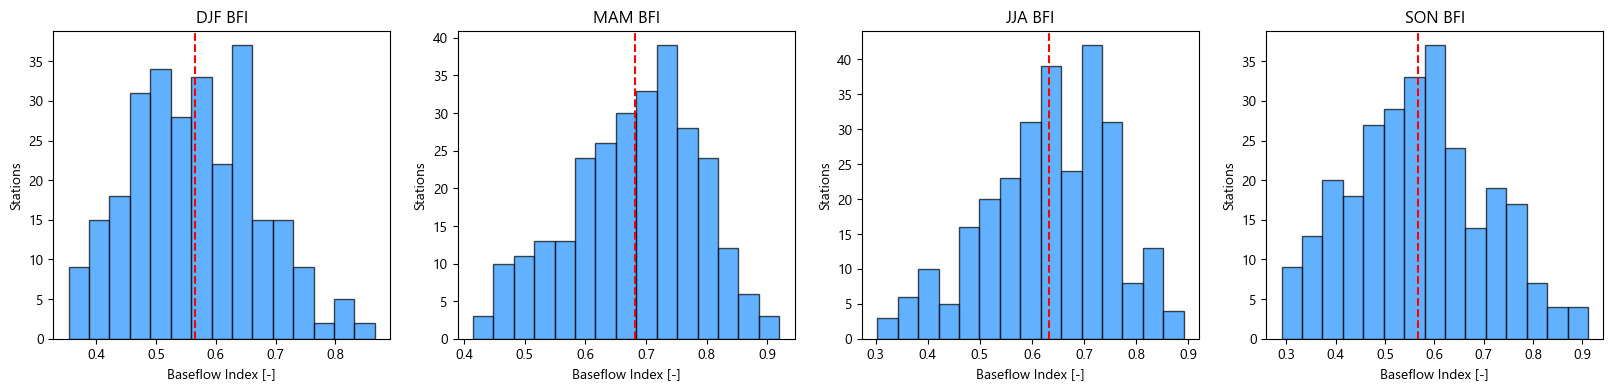

In [9]:
#seasonal baseflow histograms
fig, ax = plt.subplots(1, 4, figsize=(20, 4))
for i, season in enumerate(seasons.keys()):
    ax[i].set_title(f'{season} BFI')
    gdf_seasonal_baseflow['BFI_' + season].plot(kind='hist', ax=ax[i], bins=15, color='dodgerblue', edgecolor='black', alpha=0.7)
    ax[i].axvline(gdf_seasonal_baseflow['BFI_' + season].mean(), color='red', linestyle='--', label='Mean')
    ax[i].set_xlabel('Baseflow Index [-]')
    ax[i].set_ylabel('Stations')

In [10]:
gdf_bfi_kge['BFI'].mean(), gdf_bfi_kge['BFI'].min(), gdf_bfi_kge['BFI'].max()

(0.6042290909090909, 0.361, 0.893)

In [11]:
gdf_bfi_kge.to_csv('bfi_stations_unfiltered.csv')

#### Map BFI 

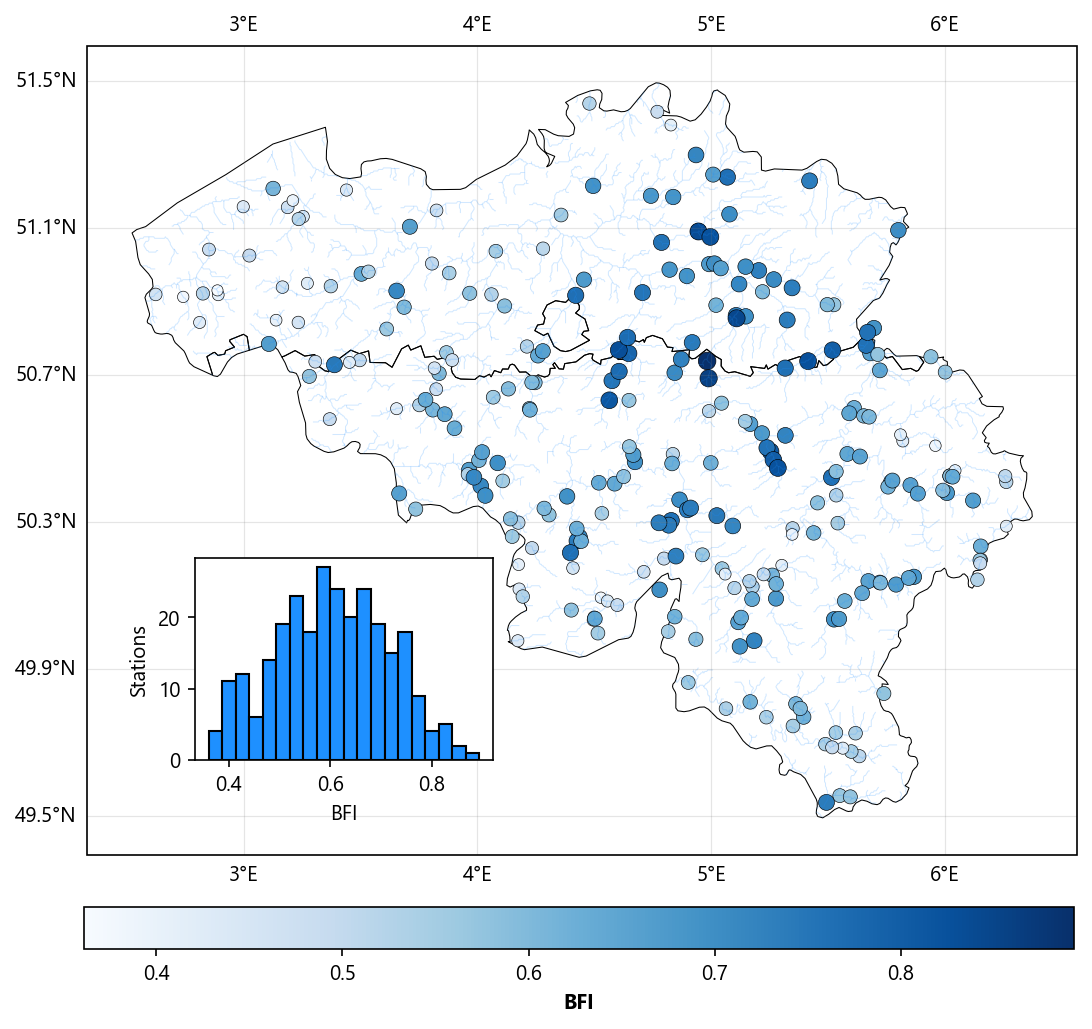

In [12]:
#### Map the BFI and KGE values
fig, ax = plt.subplots(figsize=(15, 7), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=150)

be_shp.plot(ax=ax, linewidth=0.5,
              edgecolor='black', facecolor='none', zorder=1, transform=ccrs.PlateCarree())

rivers_shp.plot(ax=ax, linewidth=0.5, alpha=0.2,
                edgecolor='dodgerblue', facecolor='none', zorder=2, transform=ccrs.PlateCarree())


sc = ax.scatter(
    gdf_bfi_kge.geometry.x, gdf_bfi_kge.geometry.y,
    c=gdf_bfi_kge['BFI'],
    s=gdf_bfi_kge['BFI']*80,
    cmap='Blues',
    #norm=norm,
    edgecolor='black',
    linewidth=0.3,
    transform=ccrs.PlateCarree()
)

gl = ax.gridlines(draw_labels=True, color='gray', lw=0.6, alpha=0.2)
gl.xlocator = plt.FixedLocator(np.arange(0, 10, 1))
gl.ylocator = plt.FixedLocator(np.arange(49.5, 51.9, 0.4))
gl.top_labels = True
gl.right_labels = False

#Insert inset histogram of BFI values
ax_inset = inset_axes(ax, width="30%", height="25%", bbox_to_anchor=(-.58, -.62, 1.0, 1.0), bbox_transform=ax.transAxes)
gdf_bfi_kge['BFI'].plot(kind='hist', ax=ax_inset, bins=20, color='dodgerblue', edgecolor='black')
ax_inset.set_ylabel('Stations')
ax_inset.set_xlabel('BFI')
#ax_inset.set_title('BFI Histogram')

# Shared colorbar
#Add colorbar
cax = fig.add_axes([0.291, 0.02, 0.44, 0.04]) #left, bottom, width, height
# Shared normalization
stat_min = gdf_bfi_kge['BFI'].min()
stat_max = gdf_bfi_kge['BFI'].max()
cmap = 'Blues'  # You can change this to any colormap you prefer
norm = Normalize(vmin=stat_min, vmax=stat_max)
cmap = plt.get_cmap(cmap)

cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='horizontal')
cbar.ax.tick_params(labelsize=10)
cbar.set_label('BFI', fontsize=10, weight='bold')

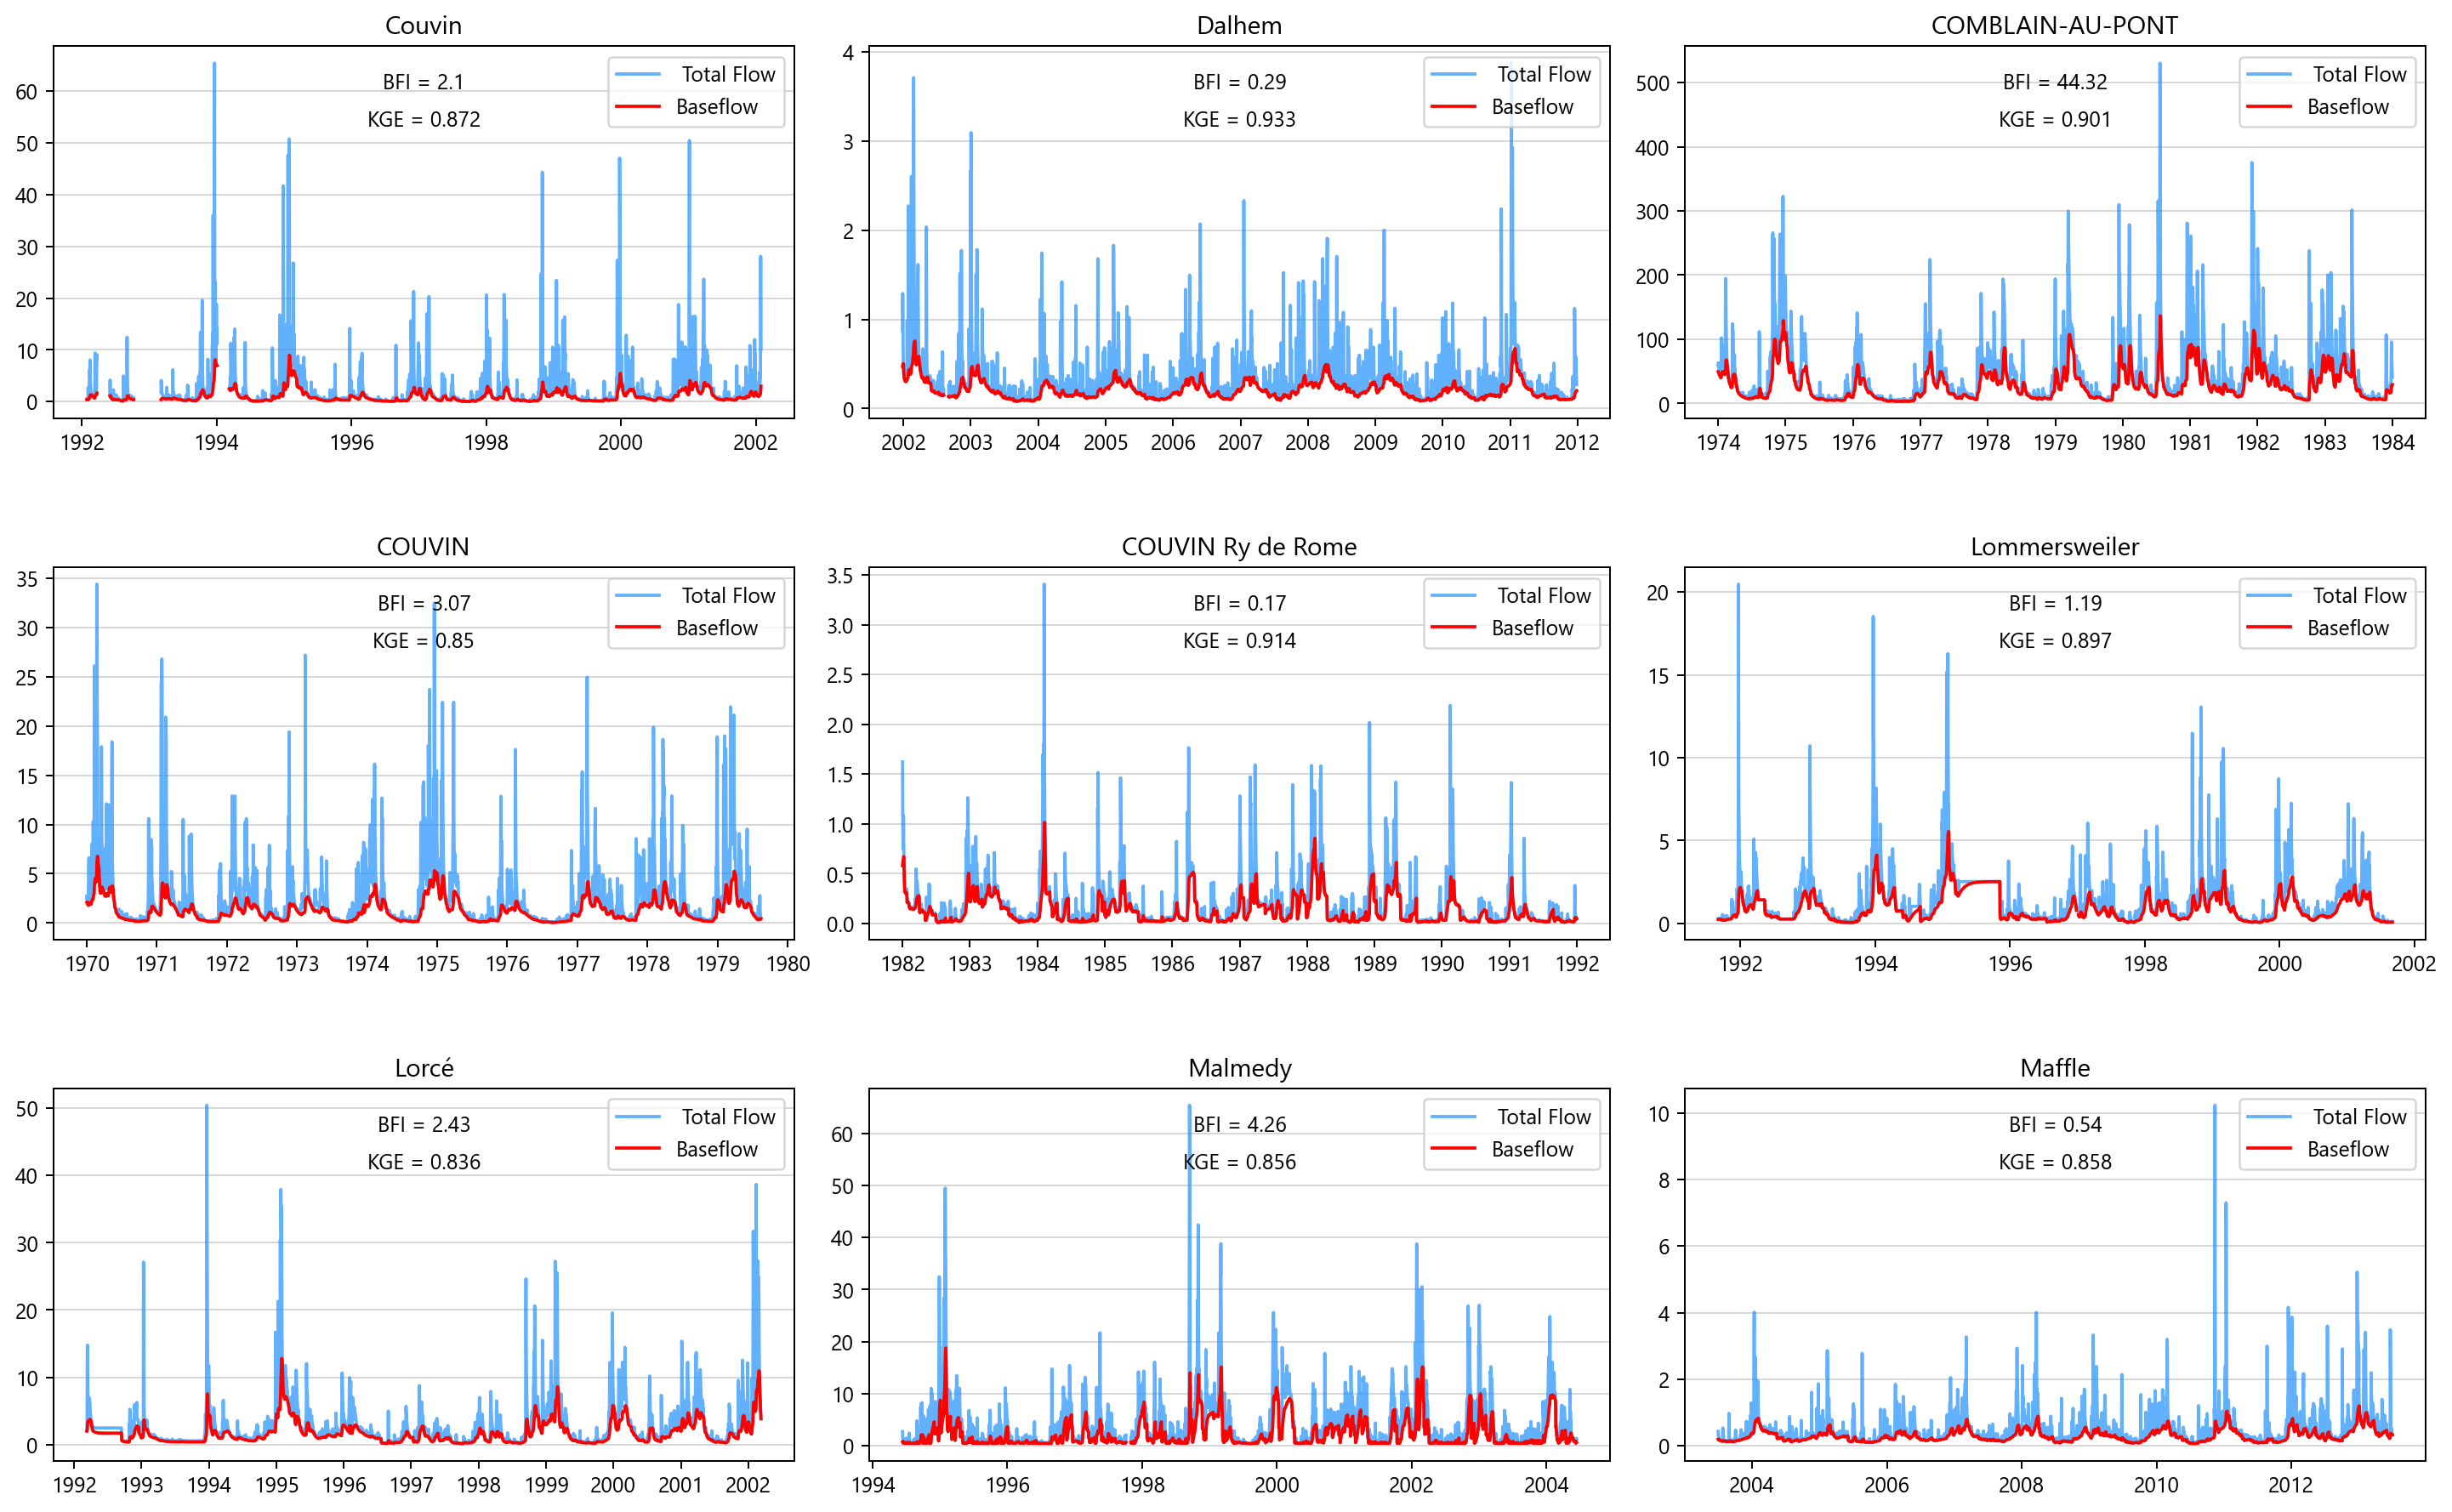

In [13]:
nrows = 3
ncols = 3

fig,axes = plt.subplots(nrows, ncols, figsize=(20,12), dpi=180)
ax = axes.flatten()

#spaces between the subplots
plt.subplots_adjust(wspace=0.1, hspace=0.4)

for ax, name in zip(ax, baseflow_dict_stations.keys()):

    df = baseflow_dict_stations[name]
    bfi = baseflow_dict_stations[name]
    kge = kge_dict[name]
    
    bfi_stat = round(bfi.mean().values[0], 2)

    #plot the hydrograph
    min_date = df.index.min()
    max_date = min_date + pd.DateOffset(years=10)

    ax.plot(df['Q'][min_date:max_date], label=' Total Flow', color='dodgerblue', alpha=0.7)   
    ax.plot(df['Q_bf'][min_date:max_date], label='Baseflow', color='r')
    ax.set_title(name)
    ax.text(0.5, 0.9, f'BFI = {bfi_stat}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.5, 0.8, f'KGE = {kge}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.grid(axis='y', alpha=0.5)
    ax.legend()

<Axes: xlabel='Date'>

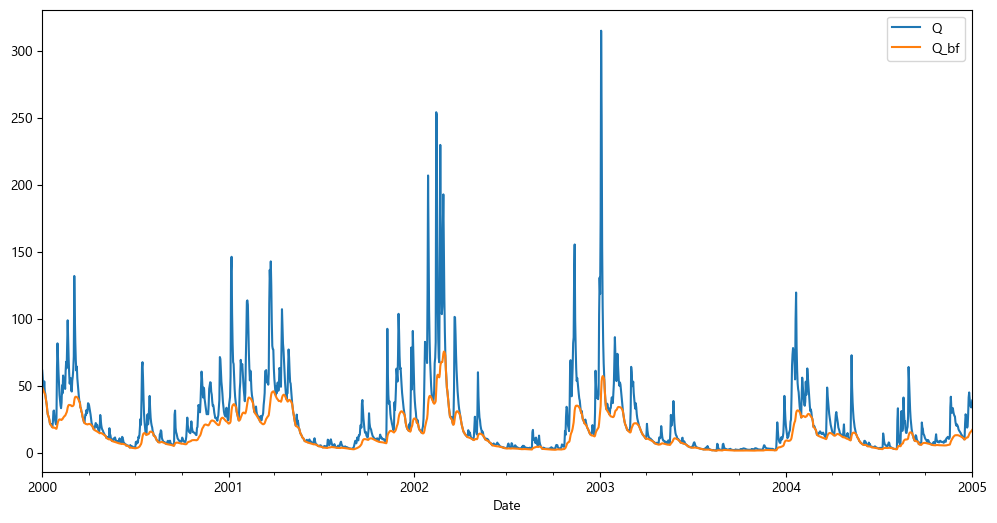

In [20]:
baseflow_dict_stations['TABREUX']['2000-01-01':'2005-01-01'].plot(figsize=(12,6))